In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os

%load_ext autoreload
%autoreload 2

This notebook reads the result of multiple (different seeded) shap value calculations and visualizes the results

In [236]:
from convection_param.HelperFuncs import unique_unsorted

data_path = '../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct.npz'
# data_path = '../../local_data/TrainData/20230210-131835-R2B5_y13y16_vcg-fluxes_rho_fluct_neglect.npz'
data = np.load(data_path)
print(data.files)

X_expl, Y_expl = data['X_expl'], data['Y_expl']

vars_to_neglect = ['qr','qs']
# vars_to_neglect = []
vars_to_neglect_mask = ~np.isin(unique_unsorted([e[0] for e in X_expl]), vars_to_neglect)
print(vars_to_neglect_mask)

X_expl = np.array([e for e in X_expl if e[0] not in vars_to_neglect])

['X_train', 'X_val', 'X_test', 'Y_train', 'Y_val', 'Y_test', 'X_expl', 'Y_expl', 'train_coords', 'val_coords', 'test_coords']
[ True  True  True  True False False  True  True  True]


In [240]:
# model_path, model_type = '../../Models/NewFormat/Torch/20230415-021732R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_hpoed/', 'unet'
model_path, model_type = '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/', 'unet_woqrqs'
dl_model = True
model_path_content = list(os.scandir(model_path))
[c.name for c in model_path_content]

['shaps_20230510-110829_seed1458.npz',
 'shaps_20230510-095616_seed745.npz',
 'shaps_20230510-114502_seed2489.npz',
 'data_desc.txt',
 'shaps_20230510-122120_seed646.npz',
 'shaps_20230510-103221_seed3452.npz',
 'model.state_dict']

In [241]:
import hashlib

model_path_normed = os.path.normpath(model_path)
if dl_model:
    model_name = os.path.basename(model_path_normed)
model_id = hashlib.sha256(model_name.encode("UTF-8")).hexdigest()[:12]
print(model_name, model_id)

20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed ebf2d92d00b5


In [242]:
X_explains = []
backgrounds = []
shaps = []
shap_files = [c.path for c in model_path_content if 'shaps_' in c.name]
# shap_files = [c.path for c in model_path_content if 'kernelexpl' in c.name]
print(shap_files)
# shap_files = ['ShapValues/20230315-111535-HistGradientBoostingRegressor_test.npz']
# shap_files = ['Models/Optimized/20230421-1613616samples/HistGradientBoostingRegressor/ShapValues/']
for f in tqdm(shap_files):
    data = np.load(f)
    X_explains.append(data['X_explain'])
    # backgrounds.append(data['background'])
    shaps.append(data['shap_values'])

X_explains = np.stack(X_explains, axis=0)
# backgrounds = np.stack(backgrounds, axis=0)
shaps = np.stack(shaps, axis=0)
print(X_explains.shape)
# print(backgrounds.shape)
print(shaps.shape)

['../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/shaps_20230510-110829_seed1458.npz', '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/shaps_20230510-095616_seed745.npz', '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/shaps_20230510-114502_seed2489.npz', '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/shaps_20230510-122120_seed646.npz', '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/shaps_20230510-103221_seed34

  0%|          | 0/5 [00:00<?, ?it/s]

(5, 1000, 7, 23)
(5, 189, 1000, 7, 23)


In [243]:
# For non-dl data:
if not dl_model:
    X_explains_new_shape = list(X_explains.shape)[:-1] + [-1, 23]
    X_explains = X_explains.reshape(X_explains_new_shape)
    shaps_new_shape = list(shaps.shape)[:-1] + [-1, 23]
    shaps = shaps.reshape(shaps_new_shape)

    print(X_explains.shape)
    print(shaps.shape)

In [244]:
X_expl_vars = [v[0] for v in X_expl]
Y_expl_vars = [v[0] for v in Y_expl]

Y_uniq_vars, Y_uniq_idx = np.unique(Y_expl_vars, return_index=True)
idx_sorted = np.argsort(Y_uniq_idx)
Y_uniq_vars = Y_uniq_vars[idx_sorted]
Y_uniq_idx = Y_uniq_idx[idx_sorted]

X_uniq_vars, X_uniq_idx = np.unique(X_expl_vars, return_index=True)
idx_sorted = np.argsort(X_uniq_idx)
X_uniq_vars = X_uniq_vars[idx_sorted]
X_uniq_idx = X_uniq_idx[idx_sorted]

In [245]:
X_explains.shape

(5, 1000, 7, 23)

In [246]:
X_explains = np.swapaxes(X_explains, 0, 1)
# backgrounds = np.swapaxes(backgrounds, 0, 1)
shaps = np.moveaxis(shaps, 0, 2)
print('X_explains shape: ', X_explains.shape)
# print('backgrounds shape: ', backgrounds.shape)
print('shaps shape: ', shaps.shape)

X_explains shape:  (1000, 5, 7, 23)
shaps shape:  (189, 1000, 5, 7, 23)


In [247]:
# shaps = np.swapaxes(shaps, 0, 1)
# shaps.shape

In [248]:
# X_explains = np.swapaxes(X_explains, 0, 1)
multiplier = X_explains - np.mean(X_explains, axis=0)
# multiplier[:,:,3:5,:] = np.abs(multiplier[:,:,3:5,:])
EPS = 1e-5
multiplier /= np.maximum(np.max(np.abs(multiplier), axis=0), 0)
# X_explains = np.swapaxes(X_explains, 0, 1)
# multiplier = np.swapaxes(multiplier, 0, 1)
multiplier.shape

(1000, 5, 7, 23)

In [249]:
shap_values3d = shaps[:-5,...]
rshape = shap_values3d.shape
rshape = [-1, 23] + list(rshape)[1:]
shap_values3d = shap_values3d.reshape(rshape)
shap_values3d.shape

(8, 23, 1000, 5, 7, 23)

In [250]:
mean_shap_values3d = np.mean(multiplier * shap_values3d, axis=2)
mean_shap_values3d.shape
#(8, 23, 6, 6, 23)

(8, 23, 5, 7, 23)

In [251]:
shap_importance3d = np.mean(np.abs(shap_values3d), axis=(0,1,2))
shap_importance3d.shape

(5, 7, 23)

In [252]:
mean_shap_values3d.shape

(8, 23, 5, 7, 23)

In [253]:
# Reverse ordering so that height increases with index

mean_shap_values3d = mean_shap_values3d[:,::-1,:,:,::-1]
shap_importance3d = shap_importance3d[:,:,::-1]
# permutation_importances = reverse_order1d(permutation_importances)

In [254]:
# mean_shap_values3d_plot = mean_shap_values3d[:,:,0,...]
# shap_importance3d_plot = shap_importance3d[0,...].flatten()
mean_shap_values3d_plot = np.mean(mean_shap_values3d, axis=2)
shap_importance3d_plot = np.mean(shap_importance3d, axis=0).flatten()
# mean_shap_values3d_plot = np.std(mean_shap_values3d, axis=2)
# shap_importance3d_plot = np.std(shap_importance3d, axis=0).flatten()
# mean_shap_values3d_plot = np.std(mean_shap_values3d, axis=2)/(np.abs(np.mean(mean_shap_values3d, axis=2))+1e-4)
# shap_importance3d_plot = np.std(shap_importance3d, axis=0).flatten()/(np.abs(np.mean(shap_importance3d, axis=0).flatten())+1e-4)
print('mean_shap_values3d_plot shape: ', mean_shap_values3d_plot.shape)

mean_shap_values3d_plot shape:  (8, 23, 7, 23)


In [255]:
print(np.max(mean_shap_values3d_plot))
print(np.quantile(mean_shap_values3d_plot.ravel(), 0.99))

0.10020652620118468
0.012480780861046193


In [256]:
test_shaps = np.mean(mean_shap_values3d, axis=2)

In [257]:
# Experimental (coefficient of variation / norm. std)
# mean_shap_values3d_plot = np.std(mean_shap_values3d, axis=2, ddof=1)
# shap_importance3d_plot = np.std(shap_importance3d, axis=0, ddof=1).flatten()

# mean_shap_values3d_plot = np.std(mean_shap_values3d, axis=2, ddof=1) / (np.mean(mean_shap_values3d, axis=2)+0)
# shap_importance3d_plot = np.std(shap_importance3d, axis=0, ddof=1).flatten() / (np.mean(shap_importance3d, axis=0).flatten()+0)

# means = np.mean(mean_shap_values3d, axis=2)
# means[np.isclose(means, 0)] = np.nan
# mean_shap_values3d_plot = np.std(mean_shap_values3d, axis=2, ddof=1) / means
# means = np.mean(shap_importance3d, axis=0)
# means[np.isclose(means, 0)] = np.nan
# shap_importance3d_plot = np.std(shap_importance3d, axis=0, ddof=1).flatten() / means.flatten()

# from scipy.stats import variation 
# mean_shap_values3d_plot = variation(mean_shap_values3d, axis=2)
# shap_importance3d_plot = variation(shap_importance3d, axis=0).flatten()

In [258]:
print(shap_importance3d_plot.max())
shap_importance3d_plot.shape

0.033056448541097086


(161,)

In [259]:
mean_shap_values3d_plot.shape

(8, 23, 7, 23)

abs_max:  0.146852815742443


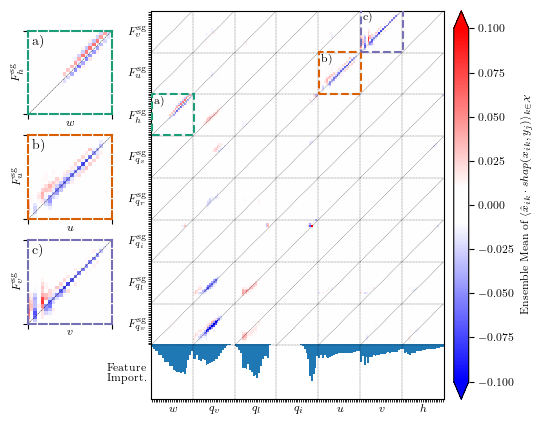

In [260]:
%matplotlib inline
shap_importance3d_plot.shape
from convection_param.Constants import label_remapping, input_var_remapping
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm, SymLogNorm, Normalize
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size, get_ax_size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

setup_mpl_tex()

shapshape = mean_shap_values3d_plot.shape
y_ext, x_ext = shapshape[0]*shapshape[1], shapshape[2]*shapshape[3]

fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('textwidth'))#(8,12))

abs_max = np.max(np.abs(mean_shap_values3d_plot))
print('abs_max: ', abs_max)
abs_max = 0.1#0.2#

cmap = 'bwr'#'seismic'#'coolwarm'#'RdBu_r'#'bwr'#'Reds'#'hot'#'bwr'#
# cmap = plt.get_cmap(cmap)
p = [-abs_max, -0.1*abs_max, 0.1*abs_max, abs_max]
f = lambda x: np.interp(x, p, [0, 0.5, 0.5, 1])
cmap = LinearSegmentedColormap.from_list('my_map', list(zip(np.linspace(0,1), plt.cm.bwr(f(np.linspace(min(p), max(p)))))))

cmap.set_bad('000000')

# X_explain_fluct = X_explain - np.mean(X_explain, axis=0)
# mean_shap_values = np.mean(np.sign(X_explain_fluct)*shap_values, axis=1)[:-5,...]
# mean_shap_values = np.mean(np.abs(shap_values[:-5,...]), axis=1)
# mean_shap_values = np.swapaxes(mean_shap_values, 1, 2)
# print(mean_shap_values.shape)
# abs_max = 0.146852815742443
mean_shap_values3d_plot_2d = mean_shap_values3d_plot.reshape(y_ext, x_ext)
im = ax.imshow(mean_shap_values3d_plot_2d,
               origin='lower',
               cmap=cmap,
               interpolation='none',
               norm=Normalize(vmin=-abs_max, vmax=abs_max))
               # norm=Normalize(vmin=0, vmax=abs_max))
               # norm=SymLogNorm(linthresh=0.001, vmin=-1000*abs_max, vmax=1000*abs_max))
               # norm=Normalize(0,1))#, linthresh=0.001))#norm=TwoSlopeNorm(0))##)
# fig.colorbar(im, orientation='horizontal', label=r'ensemble mean of $\langle mul(x_i^\prime)\cdot shap(x_i,y_j)\rangle_{Xb}$', shrink=0.8)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size=0.15, pad=0.1)
fig.colorbar(im, cax=cax1, orientation='vertical', label=r'Ensemble Mean of $\langle \hat{x}_{ik}\cdot shap(x_{ik},y_j)\rangle_{k\in \mathcal{X}}$', extend='both')

# Plot help lines
plot_diff = 0.5
for idx in Y_uniq_idx[:-5]:
    ax.axhline(idx-plot_diff, ls='--', color='black', lw=0.2)
for idx in X_uniq_idx:
    ax.axvline(idx-plot_diff, ls='--', color='black', lw=0.2)

for x_idx in X_uniq_idx:
    for y_idx in Y_uniq_idx[:-5]:
        shap_height = mean_shap_values3d_plot.shape[-1]
        ax.plot([x_idx-plot_diff,x_idx+shap_height-plot_diff], [y_idx-plot_diff,y_idx+shap_height-plot_diff], ls='--', color='black', lw=0.2)
        # mean_shap_val = mean_shap_values3d_plot_2d[y_idx:y_idx+shap_height,x_idx:x_idx+shap_height].mean()
        # print(f'{mean_shap_val:.1e}')
        # ax.text(x_idx, y_idx, f'{mean_shap_val:.1e}')
# for xidx,yidx in zip(X_uniq_idx, Y_uniq_idx[:-5]):
    # ax.plot([xidx,x_ext], [0,y_ext-5-yidx], ls='--', color='black', lw=0.2)
    # ax.plot([0,x_ext-xidx], [yidx,y_ext-5], ls='--', color='black', lw=0.2)


X_tick_labels = X_uniq_vars.copy()
X_tick_labels = [input_var_remapping[var] for var in X_tick_labels]
# X_tick_labels[X_tick_labels=='w_fl'] = 'w'
# X_tick_labels = np.concatenate([['test'], X_tick_labels])
# X_ticks = np.concatenate([[-10], X_uniq_idx])
tick_offset = 11.5
X_ticks = X_uniq_idx + tick_offset
ax.set_xticks(X_ticks, X_tick_labels)
ax.tick_params(axis='x', which='major', length=0)
# ax.set_xticks(range(X_expl.shape[0]), list(map(''.join, X_expl)))

ax.set_xticks(range(x_ext), minor=True)
ax.set_yticks(range(y_ext), minor=True)
# ax.legend()
# fig.savefig(f'Figures/ShapValues/{model_name}_importance_symlog.jpg', dpi=300)
Y_tick_labels = [label_remapping[var] for var in Y_uniq_vars[:-5]]

scale = 20#*0.005014002182269052/0.038513823887718304
# forest_importances_scaled = - forest_importances/np.max(np.abs(forest_importances)) * scale
shap_importance3d_scaled = - shap_importance3d_plot/np.max(np.abs(shap_importance3d_plot)) * scale
# permutation_importances_scaled = permutation_importances/np.max(np.abs(permutation_importances)) * scale
# ax.bar(range(len(forest_importances_scaled)), forest_importances_scaled, width=1)
ax.bar(range(len(shap_importance3d_scaled)), shap_importance3d_scaled, width=1)
# ax.bar(range(len(permutation_importances_scaled)), permutation_importances_scaled, width=1)
# rf_y_label = 'Mean\ndecrease\nin\nMSE'
rf_y_label = 'Feature\nImport.'
# rf_y_label = 'Permutation\nfeature\nimportance'
# ylims = ax.get_ylim()
# ax.set_ylim(ylims)
rf_y_position = ax.get_ylim()[0]/2
ax.set_yticks([rf_y_position]+list(Y_uniq_idx[:-5]+tick_offset), [rf_y_label]+Y_tick_labels)
# ax.set_yticks(Y_uniq_idx[:-5]+tick_offset, Y_tick_labels)

ax.tick_params(axis='y', which='major', length=0)

def draw_inset(ax, px, py, lims, labels=False, special=False, color=None, indicate_zoom_lines=True, label=None):
    color = color if color else 'black'
    # inset axes....
    bounds = lims 
    axins = ax.inset_axes(bounds, transform=ax.transData)
    # axins = inset_axes(ax, width=1, height=1, bbox_transform=ax.transAxes, bbox_to_anchor=(0, 1), loc='upper right', borderpad=0)
    # subregion of the original image
    x1, x2, y1, y2 = 23*px, 23*(px+1), 23*py, 23*(py+1)
    if special:
        axins.imshow(test_shaps,
                   origin='lower',
                   cmap=cmap,
                   interpolation='none',
                   norm=Normalize(vmin=-abs_max, vmax=abs_max))
                   # norm=Normalize(0,1))
    else:
        axins.imshow(mean_shap_values3d_plot_2d,
                   origin='lower',
                   cmap=cmap,
                   interpolation='none',
                   norm=Normalize(vmin=-abs_max, vmax=abs_max))
                   # norm=Normalize(vmin=0, vmax=abs_max))
                   # norm=Normalize(0,1))
    
    axins.plot([x1,x2], [y1,y2], ls='--', color='black', lw=0.3)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([x1,x2])
    axins.set_yticks([y1,y2])
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    if color:
        for sp in ax.spines:
            axins.spines[sp].set_color(color)
            axins.spines[sp].set_linestyle('--')
            axins.spines[sp].set_linewidth(1.5)
    if labels:
        axins.set_xlabel(X_tick_labels[px], labelpad=-4)
        axins.set_ylabel(Y_tick_labels[py], labelpad=-3)

    rect, conlines = ax.indicate_inset_zoom(axins, edgecolor=color, ls='--')
    rect.set(linewidth=1.5, alpha=1)
    if indicate_zoom_lines:
        for l in conlines:
            l.set(linestyle=':')
    else:
        for l in conlines:
            l.set(linestyle='')
    if label:
        axins.text(0+0.05, 1-0.05, label, transform=axins.transAxes, ha='left', va='top', fontsize=10)
        ax.text(x1+1, y2-1, label, ha='left', va='top', fontsize=8)

    return axins

zoom_size = 23*2
n_plots = 3
y_gap = (y_ext - zoom_size*n_plots)/(n_plots+1)
x_ll = -zoom_size - 22
p1x, p1y = 0,5
p2x, p2y = 4,6
p3x, p3y = 5,7
# p2x, p2y = 6,6
# p3x, p3y = 4,5

inset_cmap = plt.get_cmap('Dark2')#'viridis')
y1,y2,y3 = np.arange(y_gap, y_ext, zoom_size+y_gap)
inset_axs = []
inset_axs.append(draw_inset(ax, p1x, p1y, [x_ll, y3, zoom_size, zoom_size], labels=True, indicate_zoom_lines=False, label='a)', color=inset_cmap(0)))#0.1)))
inset_axs.append(draw_inset(ax, p2x, p2y, [x_ll, y2, zoom_size, zoom_size], labels=True, indicate_zoom_lines=False, label='b)', color=inset_cmap(1)))#0.4)))
inset_axs.append(draw_inset(ax, p3x, p3y, [x_ll, y1, zoom_size, zoom_size], labels=True, indicate_zoom_lines=False, label='c)', color=inset_cmap(2)))#0.7)))
# for axi,letter in zip(inset_axs, ['a)', 'b)', 'c)']):
#     axi.text(0+0.05, 1-0.05, letter, transform=axi.transAxes, ha='left', va='top', fontsize=10)
    
# fig.savefig(f'../../Figures/Pdfplots/ensmean_shap_importance-{model_type}-{model_id}-stdsamescale-noimp.pdf', bbox_inches='tight')
# fig.savefig(f'../../Figures/Pdfplots/ensmean_shap_importance-{model_type}-{model_id}-noimp-kernelexpl-1ensemblem.pdf', bbox_inches='tight')
fig.savefig(f'../../Figures/Pdfplots/ensmean_shap_importance-{model_type}-{model_id}-qualcolored_bwr_custom.pdf', bbox_inches='tight')

plt.show()